<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA22/blob/main/python/C4_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D

1. Linear ($k=1$) Finite Element Method solver for the 1D Poisson problem:

$-\Delta u=f \quad \text{in } \Omega=(a,b)$

$u|_{\partial\Omega}=0$

Import usual modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
from scipy.sparse.linalg import eigsh

FEM system assembly with trapezoidal rule for rhs

In [2]:
def FEM1_1D_TRAP(omega,N,rhs):
  # 1D FEM with k=1 system matrix and rhs for
  # diffusion problem with homogeneous Dirichlet bc
  # trapezoidal rule uniform grid

  # grid is defined here as uniform grid
  h = (omega[1]-omega[0])/N
  vertices = np.linspace(omega[0],omega[1],N+1)

  # initialise system
  A = sp.lil_matrix((N+1, N+1))
  F = np.zeros(N+1)
  
  # Assembly loop
  for i in range(N):
    # Local contributions
    ele_A = np.matrix([[1/h, -1/h],[-1/h, 1/h]])
    ele_F = 0.5 * h * rhs(vertices[i:i+2])

    # Assembly local-to-global
    A[i:i+2,i:i+2] += ele_A
    F[i:i+2] += ele_F

  # Apply boundary conditions
  A[0,0] = 1/h; A[0,1] = 0; F[0]=0
  A[N,N] = 1/h; A[N,N-1] = 0; F[N]=0  

  # return system matrix and rhs vector
  return A, F

Define FEM problem and solve

discrete max norm error =  0.008265416966228623


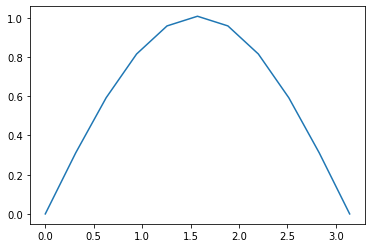

In [3]:

omega = [0,np.pi]
rhs = lambda x: np.sin(x)
exact = lambda x: np.sin(x)

N=10; 
n_qpoints = 3

# call function computing FEM system
A, F = FEM1_1D_TRAP(omega,N,rhs)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Plot solution
x = np.linspace(omega[0],omega[1],N+1)
plt.plot(x,Uh)

# Evaluate exact solution at grid nodes
U = exact(x)

# compute discrete max norm error 
print("discrete max norm error = ", max(abs(U-Uh)))

2. Repeat exercise but using arbitrary order Gauss integration and possibly nonuniform grid

In [4]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):

  # exploit numpy Gauss quadrature. This is defined in [-1,1]
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)

  return (q+1)/2, w/2

Function defining the mesh

In [5]:
def mesh(omega,N):
  return np.linspace(omega[0],omega[1],N+1)

Define reference element transformation of coordinates

In [6]:
# Transformation of coordinates functions:
# reference element -> current element
# [0,1] -> [q[i], q[i+1]]

def mapping(q, i):
    
    # check index is within range
    assert i < len(q)-1
    assert i >= 0

    return lambda x: q[i]+x*(q[i+1]-q[i])

def mapping_J(q,i):
    assert i < len(q)-1
    assert i >= 0
    return (q[i+1]-q[i])

# Linear lagrange basis on reference element
def basis1(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      phi = lambda x: 1-x
    else:
      phi = lambda x: x
    return phi

# Linear lagrange basis derivatives on reference element
def basis1_derivative(i):
    assert i < 2
    assert i >= 0
    if i == 0:
      dphi = lambda x: -np.ones(len(x))
    else:
      dphi = lambda x: np.ones(len(x))
    return dphi

FEM system assembly with Gauss integration



In [7]:
def FEM1_1D_GAUSS(omega,N,n_qpoints,rhs):
  # 1D FEM with k=1 system matrix and rhs

  # grid
  vertices = mesh(omega,N)

  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 
  phi = np.array([basis1(i)(q) for i in range(2)]).T
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise system
  A = sp.lil_matrix((N+1, N+1))
  F = np.zeros(N+1)

  # Assembly loop
  for i in range(N):
    JxW = mapping_J(vertices,i) * w
    ele_A = np.einsum('qi,qj,q',dphi,dphi,JxW) / mapping_J(vertices,i)**2#h**2
    ele_F = np.einsum('qi,q,q',phi,rhs(mapping(vertices, i)(q)),JxW)

    # Assembly local-to-global
    A[i:i+2,i:i+2] += ele_A
    F[i:i+2] += ele_F

  # return system matrix and rhs vector
  return A, F

Function implementing the boundary (nonhomogeneous) Dirichlet conditions

In [8]:
def apply_boundary_conditions(omega,N, A, F, g):
  # Ideally should scale entries as those of A
  A[0,0] = 1; A[0,1] = 0; F[0]=g(omega[0])
  A[N,N] = 1; A[N,N-1] = 0; F[N]=g(omega[1])

Define FEM problem and solve

In [9]:
omega = [0,1]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

N = 10
n_qpoints = 3

# call function computing FEM system
A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)
# and apply boundary conditions
apply_boundary_conditions(omega,N, A, F, sol)

# solve
A = A.tocsr()
Uh = sp.linalg.spsolve(A,F)

# Evaluate exact solution at grid nodes
x = np.linspace(omega[0],omega[1],N+1)
U = sol(x)

# Compute error
print("discrete max norm error = ", max(abs(U-Uh)))

discrete max norm error =  1.4876988529977098e-13


**Exercise 1**: Produce convergence plot for: 
(1) discrete max norm
(2) $\| I_h u - u_h \|_{H^1(a,b)}$ where $I_h$ is the finite element interpolant of the exact solution $u$. 

Finally, plot conditioning of the FEM system wrt $N$ and verify that this grows like $N^2$.

In [10]:
# Problem
omega = [0,1]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

# Number of quadrature points
n_qpoints = 1

# Number of experiments
no_experiments = 9

# Initialize 
NN = np.zeros(no_experiments)
discrete_max_err = np.zeros(no_experiments)
interpola_H1_err = np.zeros(no_experiments)
conditioning = np.zeros(no_experiments)

# Solution loop
for i in range(no_experiments):
  N = 2**(i+2)
  NN[i] = N

  # call function computing FEM system
  A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)

  # Save matrix A 
  S = A

  # and apply boundary conditions
  apply_boundary_conditions(omega,N, A, F, sol)

  # Compute condition number of A
  conditioning[i] = np.linalg.cond(A.todense(),p=2)

  # Solve the system
  A = A.tocsr()
  Uh = sp.linalg.spsolve(A,F)

  # Compute exact solution
  x = np.linspace(omega[0],omega[1],N+1)
  U = sol(x)

  # Compute discrete max norm error
  discrete_max_err[i] = max(abs(U-Uh))
  interpola_H1_err[i] = (U-Uh).dot(S.dot(U-Uh))


Plot results

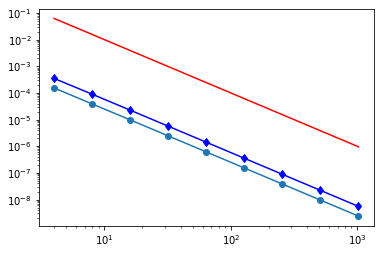

In [11]:
# Error loglog plots
plt.loglog(NN,discrete_max_err,'o-')
plt.loglog(NN,interpola_H1_err**(1/2),'bd-')
plt.loglog(NN,NN**(-2),'r')

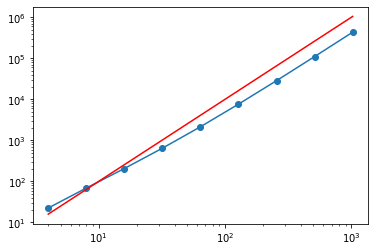

In [12]:
# Condition number plot
plt.loglog(NN,conditioning,'o-')
plt.loglog(NN,NN**(2),'r')

Function computing $H^1$-norm error

In [18]:
def FEM1_H1(omega,N,n_qpoints,Uh,dsol):
  # H1 error

  # grid
  vertices = np.linspace(omega[0],omega[1],N+1)

  # quadrature formula on reference element
  q, w = quadrature(n_qpoints)

  # Evaluation of linear Lagrange basis 
  dphi = np.array([basis1_derivative(i)(q) for i in range(2)]).T

  # initialise value of norm of error
  error = 0

  # Assembly error
  for i in range(N):
    JxW = mapping_J(vertices,i) * w
    DUUh2 = ( dsol(mapping(vertices,i)(q)) - np.einsum('i,qi',Uh[i:i+2],dphi/mapping_J(vertices,i)))**2 
    error += DUUh2.dot(JxW)

  # Return error
  return error

Test convergence this time for $\| u - u_h \|_{H^1(a,b)}$

In [19]:
import sympy as sym

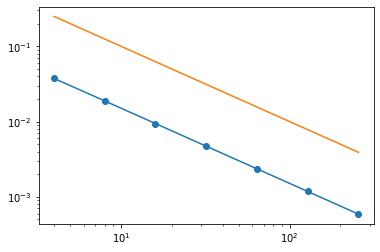

In [20]:
omega = [0,1]
rhs = lambda x: np.sin(x)

t = sym.var('t')
my_sol = sym.sin(t)
sol = sym.lambdify(t, my_sol )
d_sol = sym.lambdify(t, my_sol.diff(t, 1) )

# Number of experiments
no_experiments = 7

# Initialize 
NN = np.zeros(no_experiments)
true_H1_err = np.zeros(no_experiments)

n_qpoints = 5

for i in range(no_experiments):
  N = 2**(i+2)
  NN[i] = N

  # call function computing FEM system
  A, F = FEM1_1D_GAUSS(omega,N,n_qpoints,rhs)


  # and apply boundary conditions
  apply_boundary_conditions(omega,N, A, F, sol)


  # Solve the system
  A = A.tocsr()
  Uh = sp.linalg.spsolve(A,F)

  # Evaluate derivative of exact solution 
  true_H1_err[i] = FEM1_H1(omega,N,7,Uh,d_sol)



plt.loglog(NN,true_H1_err**(1/2),'o-')

plt.loglog(NN,NN**(-1))

**Exercise 2**: Try code with nonuniform grid 

**Exercise 3**: Write code solving general reaction-advection-diffusion problems